<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>Use Keras experiment to transfer style</font></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr> 
   <tr style="border: none">
       <td style="border: none"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1513px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg" width="500" alt="Icon"></td>
   </tr>
</table>

This notebook contains the steps and code required to demonstrate style transfer technique using Watson Machine Learning Service. This notebook introduces commands for getting data, training_definition persistence to Watson Machine Learning repository and model training.

Some familiarity with Python is helpful. This notebook uses Python 3.6 and <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/environments-parent.html" target="_blank" rel="noopener no referrer">Watson Studio environments.</a>


## Learning goals

In this notebook you learn to work with Watson Machine Learning experiments to train Deep Learning models (Keras).


## Contents


1.	[Set up](#setup)
2.	[Create the training definition](#definition)
3.	[Define the experiment](#experiment)
4.	[Run the experiment](#run)
5.	[Results](#results)
6.	[Summary](#summary)

<a id="setup"></a>
## 1. Set up

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://cloud.ibm.com/catalog/services/machine-learning" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance (a free plan is offered and information about how to create the instance is <a href="https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener no referrer">here</a>).
-  Create a <a href="https://cloud.ibm.com/catalog/services/cloud-object-storage" target="_blank" rel="noopener no referrer">Cloud Object Storage (COS)</a> instance (a lite plan is offered and information about how to order storage is <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml_dlaas_object_store.html?audience=wdp" target="_blank" rel="noopener no referrer">here</a>). <br/>**Note: When using Watson Studio, you already have a COS instance associated with the project you are running the notebook in.**
- Create new credentials with HMAC: 
    - Go to your COS dashboard.
    - In the **Service credentials** tab, click **New Credential+**.
    - Add the inline configuration parameter: {"HMAC":true}, click **Add**. (For more information, see <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml_dlaas_object_store.html#createcredentials" target="_blank" rel="noopener no referrer">HMAC</a>.)

    This configuration parameter adds the following section to the instance credentials, (for use later in this notebook):
    ```
      "cos_hmac_keys": {
            "access_key_id": "-------",
            "secret_access_key": "-------"
       }
    ```

In this section:
- [Work with Cloud Object Storage (COS)](#workcos)
- [Download training data and upload it to COS buckets](#download)
- [Work with the Watson Machine Learning instance](#wmlinstance)

### 1.1 Work with Cloud Object Storage (COS)<a id="workcos"></a>

Import the Boto library, which allows Python developers to manage COS.

In [1]:
# Import the boto library
import ibm_boto3
from ibm_botocore.client import Config
import os
import json
import warnings
import urllib
import time
warnings.filterwarnings('ignore')

Authenticate to COS and define the endpoint you will use. 

1. Enter your COS credentials in the following cell. 
You can find these credentials in your COS instance dashboard under the **Service credentials** tab as described in the [set up](#setup) section.

2. Go to the **Endpoint** tab in the COS instance's dashboard to get the endpoint information, for example: `s3-api.us-geo.objectstorage.softlayer.net`.


In [2]:
# Enter your COS credentials.
cos_credentials = {
  "apikey": "***",
  "cos_hmac_keys": {
    "access_key_id": "***",
    "secret_access_key": "***"
  },
  "endpoints": "https://cos-service.bluemix.net/endpoints",
  "iam_apikey_description": "***",
  "iam_apikey_name": "***",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "***",
  "resource_instance_id": "***"
}

In [4]:
api_key = cos_credentials['apikey']
service_instance_id = cos_credentials['resource_instance_id']
auth_endpoint = 'https://iam.bluemix.net/oidc/token'
# Enter your Endpoint information.
service_endpoint = 'https://s3-api.us-geo.objectstorage.softlayer.net'

Create the Boto resource by providing type, endpoint_url and credentials.

In [5]:
cos = ibm_boto3.resource('s3',
                         ibm_api_key_id=api_key,
                         ibm_service_instance_id=service_instance_id,
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)

Create the buckets you will use to store training data and training results.

**Note:** Bucket names must be unique.

In [6]:
# Create two buckets, style-data-example and style-results-example
from uuid import uuid4

bucket_uid = str(uuid4())

buckets = ['style-data-example-' + bucket_uid, 'style-results-example-' + bucket_uid]
for bucket in buckets:
    if not cos.Bucket(bucket) in cos.buckets.all():
        print('Creating bucket "{}"...'.format(bucket))
        try:
            cos.create_bucket(Bucket=bucket)
        except ibm_boto3.exceptions.ibm_botocore.client.ClientError as e:
            print('Error: {}.'.format(e.response['Error']['Message']))

Creating bucket "style-data-example-6b6ea109-564f-41d2-b2e6-83dddefb1dbd"...
Creating bucket "style-results-example-6b6ea109-564f-41d2-b2e6-83dddefb1dbd"...


You have now created two new buckets:
- `style-data-example`
- `style-results-example`

Display a list of buckets for your COS instance to verify that the buckets were created.

In [7]:
# Display the buckets
print([x.name for x in list(cos.buckets.all()) if x.name.startswith('style')])

['style-data-example-6b6ea109-564f-41d2-b2e6-83dddefb1dbd', 'style-results-example-6b6ea109-564f-41d2-b2e6-83dddefb1dbd']


### 1.2 Download training data and upload it to COS buckets<a id="download"></a>

Download your training data and upload them to the 'training-data' bucket.
Then, create a list of links for the training dataset.

The following code snippet creates the `STYLE_DATA` folder and downloads the files from the links to the folder.

**Tip:** First, use the `!pip install wget` command to install the wget library:


In [ ]:
!pip install --upgrade wget

In [9]:
import wget, os

# Create folder
data_dir = 'STYLE_DATA'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

links = ['https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
         'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1513px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg',
         'https://upload.wikimedia.org/wikipedia/commons/5/52/Krak%C3%B3w_239a.jpg',
         'https://upload.wikimedia.org/wikipedia/commons/3/3f/Kandinsky%2C_Lyrisches.jpg']

# Download the links to the folder
for i in range(len(links)):
    if 'Gogh' in links[i]: 
        filepath = os.path.join(data_dir, 'van_gogh.jpg')
    elif 'Krak' in links[i]: 
        filepath = os.path.join(data_dir, 'krakow.jpg')
    elif 'Kandinsky' in links[i]:
        filepath = os.path.join(data_dir, 'kandinsky.jpg')
    else:
        filepath = os.path.join(data_dir, os.path.join(links[i].split('/')[-1]))

    if not os.path.isfile(filepath):
        print(links[i])
        urllib.request.urlretrieve(links[i], filepath)

# List the files in the STYLE_DATA folder        
!ls STYLE_DATA

kandinsky.jpg  van_gogh.jpg
krakow.jpg     vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5


### Base image: Cracow - main market square

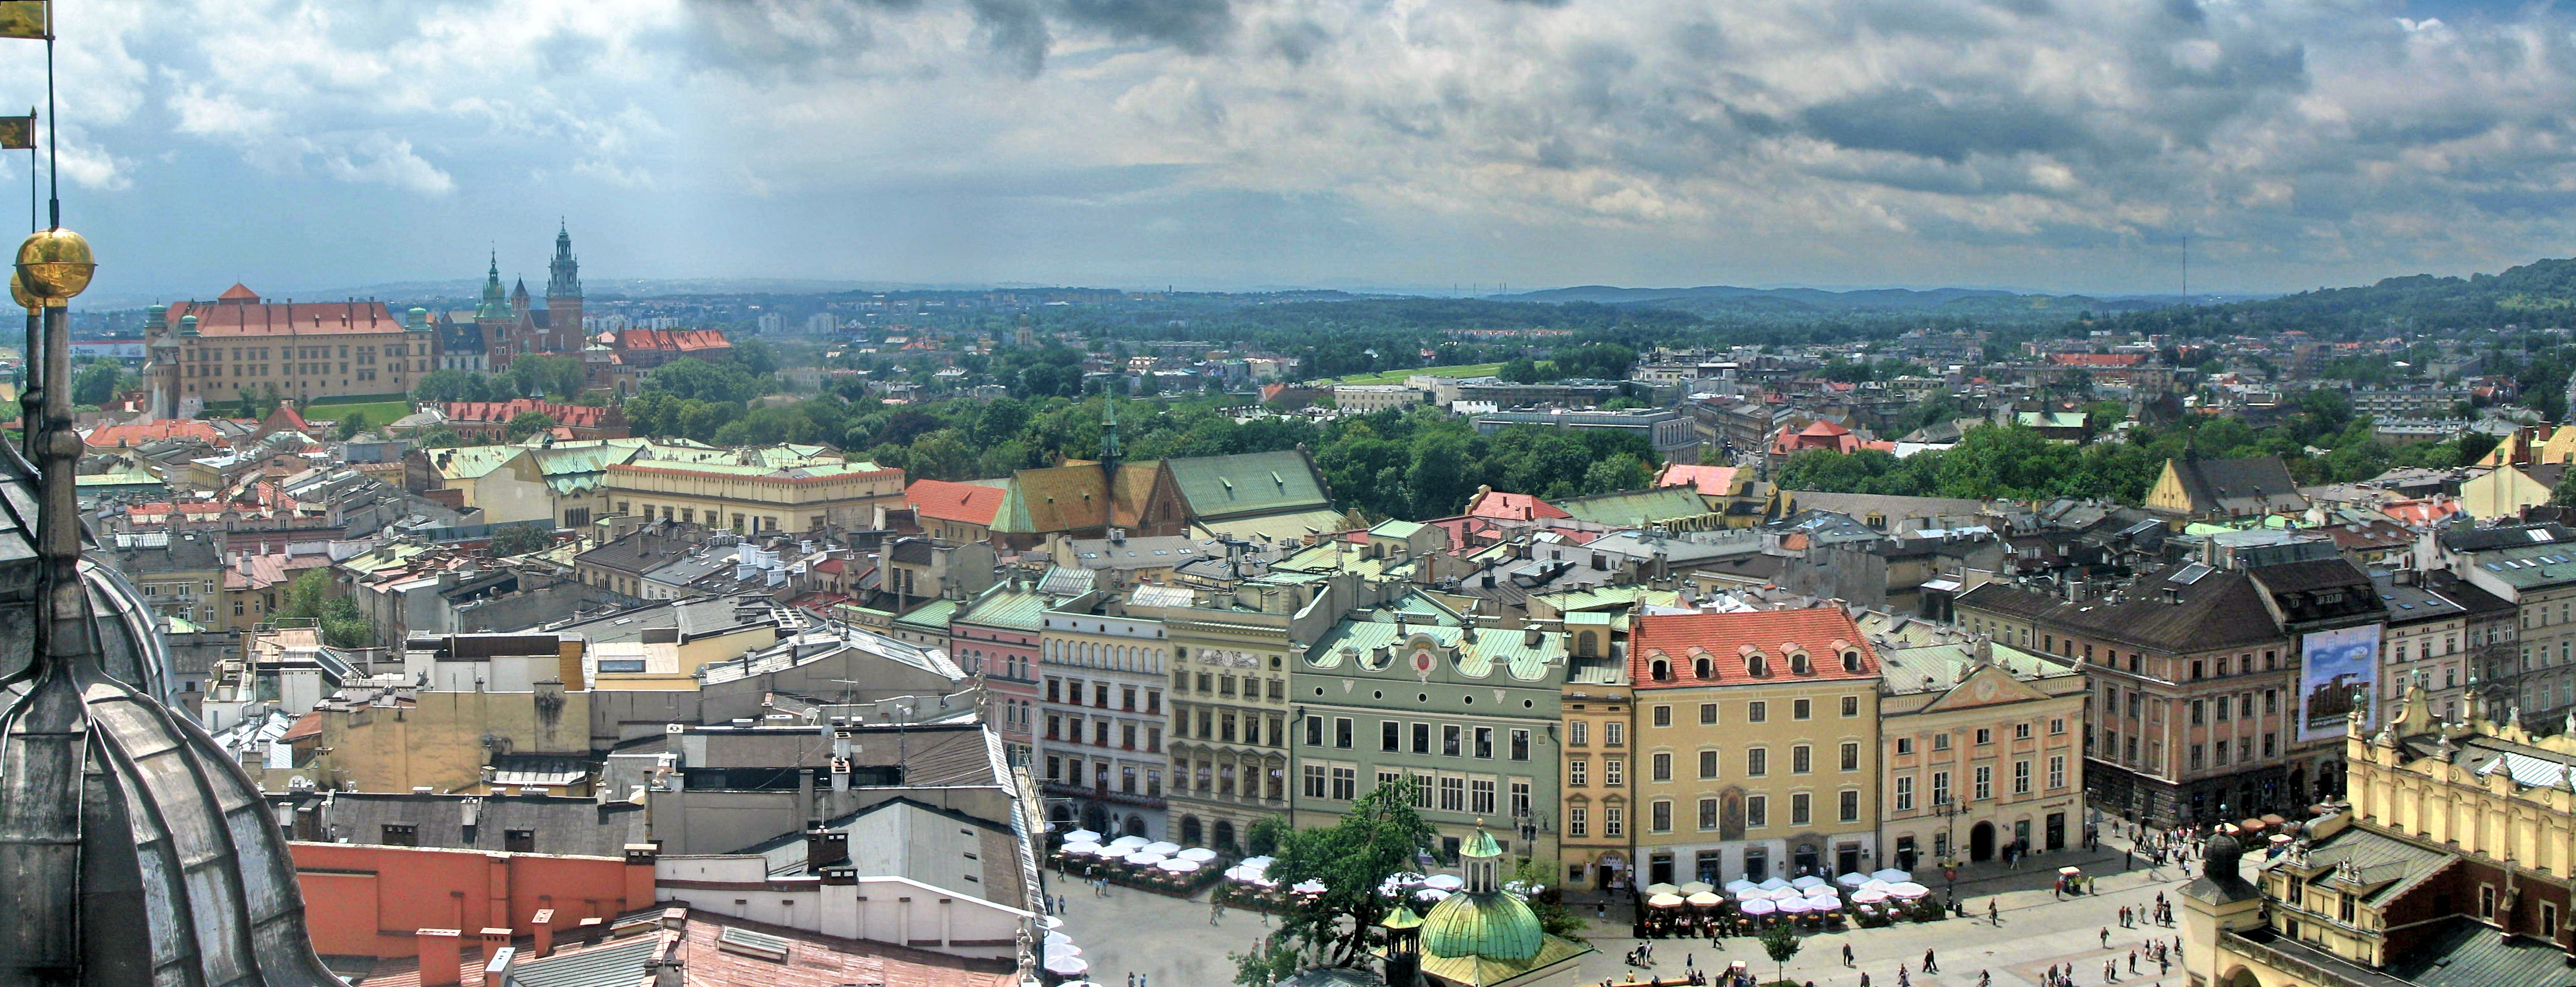

In [10]:
from IPython.display import Image
Image(filename=os.path.join(data_dir, 'krakow.jpg'), width=1000)

### Style image 1: Vincent Van Gogh - Starry Night

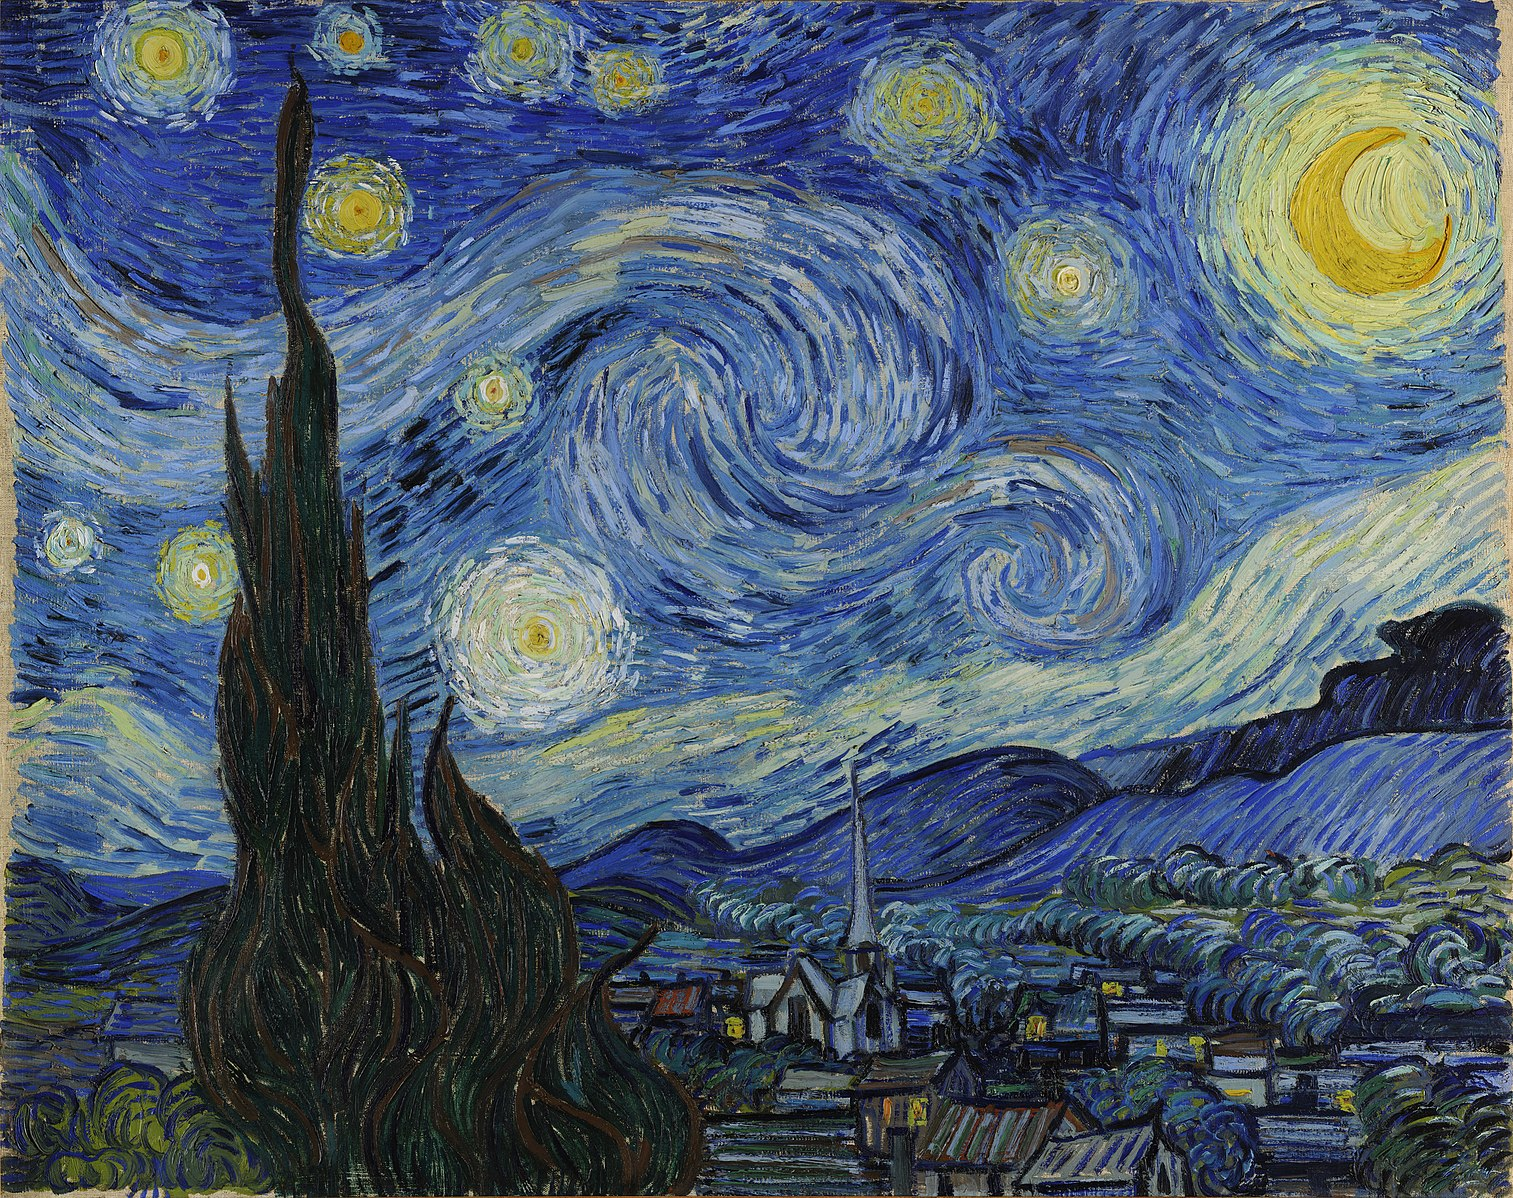

In [11]:
Image(filename=os.path.join(data_dir, 'van_gogh.jpg'), width=500)

<HR>

### Style image 2: Kandinsky Lyrisches

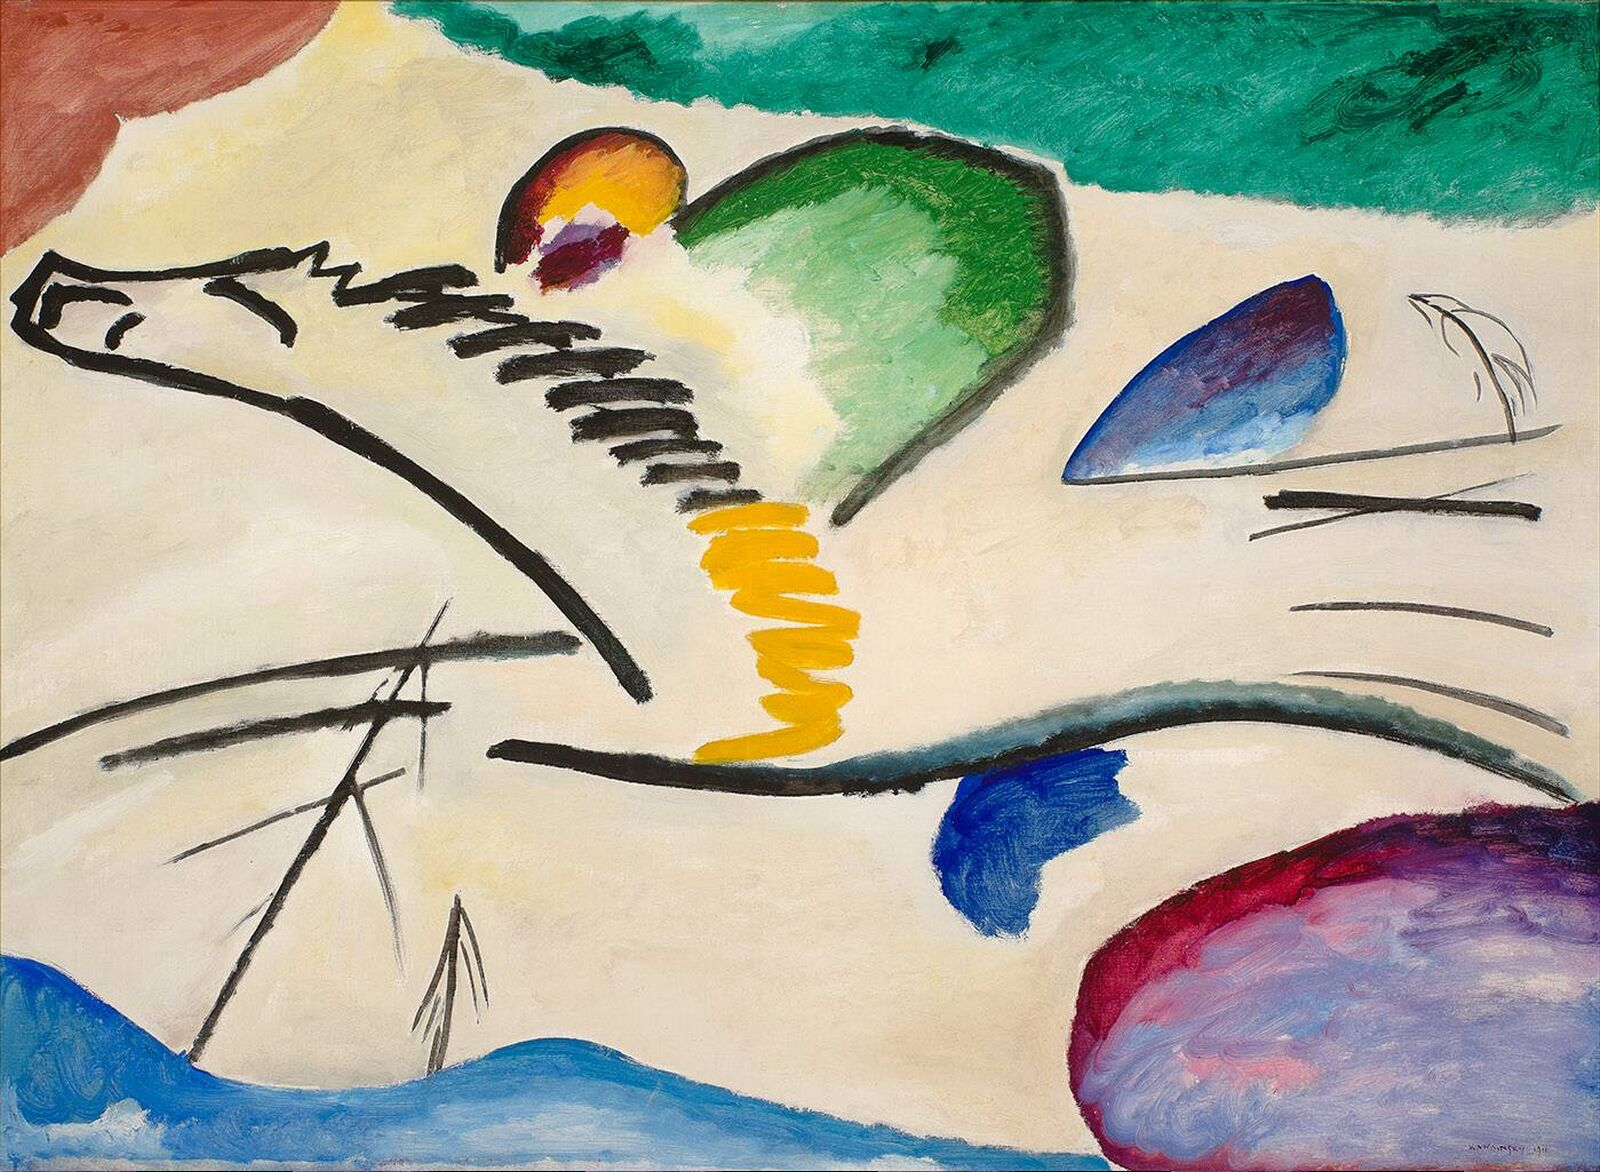

In [12]:
Image(filename=os.path.join(data_dir, 'kandinsky.jpg'), width=600)

Upload the data files to the created buckets.

In [13]:
bucket_name = buckets[0]
bucket_obj = cos.Bucket(bucket_name)

In [14]:
for filename in os.listdir(data_dir):
    with open(os.path.join(data_dir, filename), 'rb') as data: 
        bucket_obj.upload_file(os.path.join(data_dir, filename), filename)
        print('{} is uploaded.'.format(filename))

vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5 is uploaded.
van_gogh.jpg is uploaded.
krakow.jpg is uploaded.
kandinsky.jpg is uploaded.


Let's see the list of all the buckets and their contents.

In [15]:
for obj in bucket_obj.objects.all():
    print('Object key: {}'.format(obj.key))
    print('Object size (kb): {}'.format(obj.size/1024))

Object key: kandinsky.jpg
Object size (kb): 337.97265625
Object key: krakow.jpg
Object size (kb): 2063.50390625
Object key: van_gogh.jpg
Object size (kb): 833.9755859375
Object key: vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5
Object size (kb): 78256.46875


You are done with COS, and you are now ready to train your model!

### 1.3 Work with the Watson Machine Learning instance<a id="wmlinstance"></a>

Load the libraries you need.

In [16]:
import urllib3, requests, json, base64, time, os

Authenticate to the Watson Machine Learning (WML) service on IBM Cloud.

**Tip**: Authentication information (your credentials) can be found in the <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-get-wml-credentials.html" target="_blank" rel="noopener noreferrer">Service credentials</a> tab of the service instance that you created on IBM Cloud. 
If there are no credentials listed for your instance in **Service credentials**, click **New credential (+)** and enter the information required to generate new authentication information. 

**Action**: Enter your WML service instance credentials here.

In [17]:
wml_credentials = {
    "apikey": "***",
    "instance_id": "***",
    "url": "https://ibm-watson-ml.mybluemix.net"
}

#### Install the `watson-machine-learning-client` from pypi.

In [ ]:
!pip install --upgrade watson-machine-learning-client

#### Import the `watson-machine-learning-client` and authenticate to the service instance.

In [20]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

In [21]:
client = WatsonMachineLearningAPIClient(wml_credentials)

In [22]:
print(client.version)

1.0.378


**Note:** `watson-machine-learning-client` documentation can be found [here](http://wml-api-pyclient.mybluemix.net/).

<a id="definition"></a>
## 2. Create the training definitions

- [2.1 Prepare the training definition metadata](#prep)
- [2.2 Get the sample model definition content files from Git](#get)
- [2.3 Store the training definition in the WML repository](#store)

### 2.1 Prepare the training definition metadata<a id="prep"></a>

**Hint:** The final effect depends on number of iterations, and that the number of iterations impacts the training time.

In [23]:
#Set the number of iterations.
iters = 1

In [24]:
model_definition_1_metadata = {
            client.repository.DefinitionMetaNames.NAME: "style transfer van gogh",
            client.repository.DefinitionMetaNames.FRAMEWORK_NAME: "tensorflow",
            client.repository.DefinitionMetaNames.FRAMEWORK_VERSION: "1.15",
            client.repository.DefinitionMetaNames.RUNTIME_NAME: "python",
            client.repository.DefinitionMetaNames.RUNTIME_VERSION: "3.6",
            client.repository.DefinitionMetaNames.EXECUTION_COMMAND: "python style_transfer.py krakow.jpg van_gogh.jpg krakow --iter " + str(iters)
            }

In [25]:
model_definition_2_metadata = {
            client.repository.DefinitionMetaNames.NAME: "style transfer kandinsky",
            client.repository.DefinitionMetaNames.FRAMEWORK_NAME: "tensorflow",
            client.repository.DefinitionMetaNames.FRAMEWORK_VERSION: "1.15",
            client.repository.DefinitionMetaNames.RUNTIME_NAME: "python",
            client.repository.DefinitionMetaNames.RUNTIME_VERSION: "3.6",
            client.repository.DefinitionMetaNames.EXECUTION_COMMAND: "python style_transfer.py krakow.jpg kandinsky.jpg krakow --iter " + str(iters)
            }

### 2.2 Get the sample model definition content files from Git<a id="get"></a>

In [26]:
!rm -rf STYLE.zip

In [ ]:
filename_definition = 'STYLE.zip'

if not os.path.isfile(filename_definition):
    !wget https://github.com/pmservice/wml-sample-models/raw/master/keras/style/definition/STYLE.zip
    
!ls STYLE.zip

### 2.3 Store the training definition in the WML repository<a id="store"></a>

#### Store definition 1

In [28]:
definition_details = client.repository.store_definition(filename_definition, model_definition_1_metadata)

definition_url = client.repository.get_definition_url(definition_details)
definition_uid = client.repository.get_definition_uid(definition_details)
print(definition_url)

https://us-south.ml.cloud.ibm.com/v3/ml_assets/training_definitions/a84cd091-d6a6-4d33-b5b4-f2882b4f23cc


#### Store definition 2

In [29]:
definition_2_details = client.repository.store_definition(filename_definition, model_definition_2_metadata)

definition_2_url = client.repository.get_definition_url(definition_2_details)
definition_2_uid = client.repository.get_definition_uid(definition_2_details)
print(definition_2_url)

https://us-south.ml.cloud.ibm.com/v3/ml_assets/training_definitions/f655b11d-3f53-4ee6-91b4-e8511c2c6563


#### List the stored definitions

In [30]:
client.repository.list_definitions()

------------------------------------  ------------------------  ------------------------  ----------
GUID                                  NAME                      CREATED                   FRAMEWORK
f655b11d-3f53-4ee6-91b4-e8511c2c6563  style transfer kandinsky  2020-05-14T07:30:47.668Z  tensorflow
a84cd091-d6a6-4d33-b5b4-f2882b4f23cc  style transfer van gogh   2020-05-14T07:30:43.614Z  tensorflow
------------------------------------  ------------------------  ------------------------  ----------


<a id="experiment"></a>
## 3. Create the experiment definition

Get a list of supported configuration parameters.

In [31]:
client.repository.ExperimentMetaNames.show()

--------------------------  ----  --------
META_PROP NAME              TYPE  REQUIRED
NAME                        str   Y
DESCRIPTION                 str   N
TAGS                        list  N
AUTHOR_NAME                 str   N
EVALUATION_METHOD           str   N
EVALUATION_METRICS          list  N
TRAINING_REFERENCES         list  Y
TRAINING_DATA_REFERENCE     dict  Y
TRAINING_RESULTS_REFERENCE  dict  Y
--------------------------  ----  --------


Create an experiment, which will train two models based on previously stored definitions.

In [32]:
TRAINING_DATA_REFERENCE = {
                            "connection": {
                                "endpoint_url": service_endpoint,
                                "access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                                "secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                            },
                            "source": {
                                "bucket": buckets[0],
                            },
                            "type": "s3"
                        }

In [33]:
TRAINING_RESULTS_REFERENCE = {
                            "connection": {
                                "endpoint_url": service_endpoint,
                                "access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                                "secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                            },
                            "target": {
                                "bucket": buckets[1],
                            },
                            "type": "s3"
                        }

In [34]:
experiment_metadata = {
            client.repository.ExperimentMetaNames.NAME: "STYLE experiment",
            client.repository.ExperimentMetaNames.TRAINING_DATA_REFERENCE: TRAINING_DATA_REFERENCE,
            client.repository.ExperimentMetaNames.TRAINING_RESULTS_REFERENCE: TRAINING_RESULTS_REFERENCE,
            client.repository.ExperimentMetaNames.TRAINING_REFERENCES: [
                        {
                            "name": "van gogh - cracow",
                            "training_definition_url": definition_url,
                            "compute_configuration": {"name": "k80x4"}
                        },
                        {
                            "name": "kandinsky - cracow",
                            "training_definition_url": definition_2_url,
                            "compute_configuration": {"name": "k80x4"}
                        },
                    ],
                }

Store the experiment in the WML repository.

In [35]:
# Store the experiment and display the experiment_uid.
experiment_details = client.repository.store_experiment(meta_props=experiment_metadata)

experiment_uid = client.repository.get_experiment_uid(experiment_details)
print(experiment_uid)

07588c53-6ba8-4024-81e9-1ca88e1ae38c


List the stored experiments.

In [36]:
client.repository.list_experiments()

------------------------------------  ----------------  ------------------------
GUID                                  NAME              CREATED
07588c53-6ba8-4024-81e9-1ca88e1ae38c  STYLE experiment  2020-05-14T07:30:50.066Z
------------------------------------  ----------------  ------------------------


Get the experiment definition details

In [37]:
details = client.repository.get_experiment_details(experiment_uid)

<a id="run"></a>
## 4. Run the experiment

**Tip:** To run the experiment in the background, set the optional parameter `asynchronous=True` (or remove it).

In [38]:
experiment_run_details = client.experiments.run(experiment_uid, asynchronous=False)



#########################################################

Running '07588c53-6ba8-4024-81e9-1ca88e1ae38c' experiment

#########################################################


Experiment run uid: 5aadf8b5-719b-4b98-89ac-f8e389816e1c

0%   - Processing model-0fekijng (1/2): experiment_state=pending, training_state=pending
0%   - Processing model-0fekijng (1/2): experiment_state=running, training_state=pending
0%   - Processing model-0fekijng (1/2): experiment_state=running, training_state=running
50%  - Processing model-nm9lb35m (2/2): experiment_state=running, training_state=running
100% - Processing model-nm9lb35m (2/2): experiment_state=completed, training_state=completed
100% - Finished processing training runs: experiment_state=completed


--------------------------------------------------------------------
Run of '07588c53-6ba8-4024-81e9-1ca88e1ae38c' finished successfully.
--------------------------------------------------------------------




In [39]:
client.experiments.list_runs()

------------------------------------  ------------------------------------  -----------------  ---------  ------------------------
GUID (experiment)                     GUID (run)                            NAME (experiment)  STATE      CREATED
07588c53-6ba8-4024-81e9-1ca88e1ae38c  5aadf8b5-719b-4b98-89ac-f8e389816e1c  STYLE experiment   completed  2020-05-14T07:30:50.632Z
------------------------------------  ------------------------------------  -----------------  ---------  ------------------------


As you can see, the experiment run has finished.

#### Get the experiment run UID.

In [40]:
experiment_run_id = client.experiments.get_run_uid(experiment_run_details)
print(experiment_run_id)

5aadf8b5-719b-4b98-89ac-f8e389816e1c


#### Get the run details.
The code in the following cell gets details about a particular experiment run.

In [41]:
run_details = client.experiments.get_run_details(experiment_run_id)

In [42]:
run_details

{'entity': {'experiment_run_status': {'current_at': '2020-05-14T07:30:50.782Z',
   'current_iteration': 1,
   'state': 'completed',
   'submitted_at': '2020-05-14T07:30:50.782Z'},
  'training_statuses': [{'current_at': '2020-05-14T07:34:04.207Z',
    'finished_at': '2020-05-14T07:33:11.627Z',
    'message': 'training-cY3sQKgGR: ',
    'metrics': [],
    'results': {'reference': {'connection': {'access_key_id': '85a646b8ce7e4e068ba082af89021428',
       'endpoint_url': 'https://s3-api.us-geo.objectstorage.softlayer.net',
       'secret_access_key': '054c0dbf8e0baf67866a2ba8be7d997ddcef8c34f5136466'},
      'location': {'bucket': 'style-results-example-6b6ea109-564f-41d2-b2e6-83dddefb1dbd',
       'file_name': 'model-0fekijng',
       'model_location': 'training-cY3sQKgGR'},
      'type': 's3'}},
    'running_at': '2020-05-14T07:31:07.005Z',
    'state': 'completed',
    'submitted_at': '2020-05-14T07:30:52.675Z',
    'training_definition_url': 'https://us-south.ml.cloud.ibm.com/v3/ml_as

#### Get the experiment run status.
Call `client.experiments.get_status(run_uid)` to check the experiment run status. This is useful when you run an experiment in the background.

In [43]:
status = client.experiments.get_status(experiment_run_id)
print(status)

{'current_at': '2020-05-14T07:30:50.782Z', 'current_iteration': 1, 'state': 'completed', 'submitted_at': '2020-05-14T07:30:50.782Z'}


#### Monitor the experiment run.
Call `client.experiments.monitor_logs(run_uid)` to monitor the experiment run. This method streams the training logs content to the console.

In [44]:
client.experiments.monitor_logs(experiment_run_id)



########################################################################

Monitor started for experiment run: 5aadf8b5-719b-4b98-89ac-f8e389816e1c

########################################################################




####################################################

Log monitor started for training run: model-0fekijng

####################################################


Training with training/test data at:
  DATA_DIR: /mnt/data/style-data-example-6b6ea109-564f-41d2-b2e6-83dddefb1dbd
  MODEL_DIR: /job/model-code
  TRAINING_JOB: 
  TRAINING_COMMAND: python style_transfer.py krakow.jpg kandinsky.jpg krakow --iter 1
Storing trained model at:
  RESULT_DIR: /mnt/results/style-results-example-6b6ea109-564f-41d2-b2e6-83dddefb1dbd/training-cY3sQKgGR
Thu May 14 07:31:08 UTC 2020: Running Tensorflow job
2020-05-14 07:31:08.705317: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Using TensorFlow backend.
W0514 0

Training with training/test data at:
  DATA_DIR: /mnt/data/style-data-example-6b6ea109-564f-41d2-b2e6-83dddefb1dbd
  MODEL_DIR: /job/model-code
  TRAINING_JOB: 
  TRAINING_COMMAND: python style_transfer.py krakow.jpg van_gogh.jpg krakow --iter 1
Storing trained model at:
  RESULT_DIR: /mnt/results/style-results-example-6b6ea109-564f-41d2-b2e6-83dddefb1dbd/training-PUqywFRMg
Thu May 14 07:31:04 UTC 2020: Running Tensorflow job
2020-05-14 07:31:05.143294: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Using TensorFlow backend.
W0514 07:31:08.302912 140316975736640 module_wrapper.py:139] From /opt/anaconda/envs/wmlce/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0514 07:31:08.306122 140316975736640 module_wrapper.py:139] From /opt/anaconda/envs/wmlce/lib/python3.6/site-packages/keras/backend/tensorflow_backend.p

#### List the training runs triggered by experiment run.

In [45]:
client.experiments.list_training_runs(experiment_run_id)

---------------  ------------------  ---------  ------------------------  ------------------------  -----------
GUID (training)  NAME                STATE      SUBMITTED                 FINISHED                  PERFORMANCE
model-0fekijng   kandinsky - cracow  completed  2020-05-14T07:30:52.675Z  2020-05-14T07:33:11.627Z  -
model-nm9lb35m   van gogh - cracow   completed  2020-05-14T07:30:52.604Z  2020-05-14T07:34:10.674Z  -
---------------  ------------------  ---------  ------------------------  ------------------------  -----------


As you can see, two training runs completed. 

In [46]:
training_uids = client.experiments.get_training_uids(experiment_run_details)

In [47]:
# List the training uids.
training_uids = [run_details['entity']['training_statuses'][i]['results']['reference']['location']['model_location'] for i in [0,1]]
print(training_uids)

['training-cY3sQKgGR', 'training-PUqywFRMg']


## 5. Results - transferred styles images<a id="results"></a>

In [48]:
bucket_name = buckets[1]
bucket_obj = cos.Bucket(bucket_name)

In [49]:
transfered_images = []

for uid in training_uids:
    obj = bucket_obj.Object(uid + '/transfered_images/krakow_at_iteration_' + str(iters-1) + '.png')
    filename = 'krakow_transfered_' + str(uid) + '.jpg'
    transfered_images.append(filename)
    with open(filename, 'wb') as data:
        obj.download_fileobj(data)
    print(filename)

krakow_transfered_training-cY3sQKgGR.jpg
krakow_transfered_training-PUqywFRMg.jpg


### Cracow 
Have a look at the original picture again.

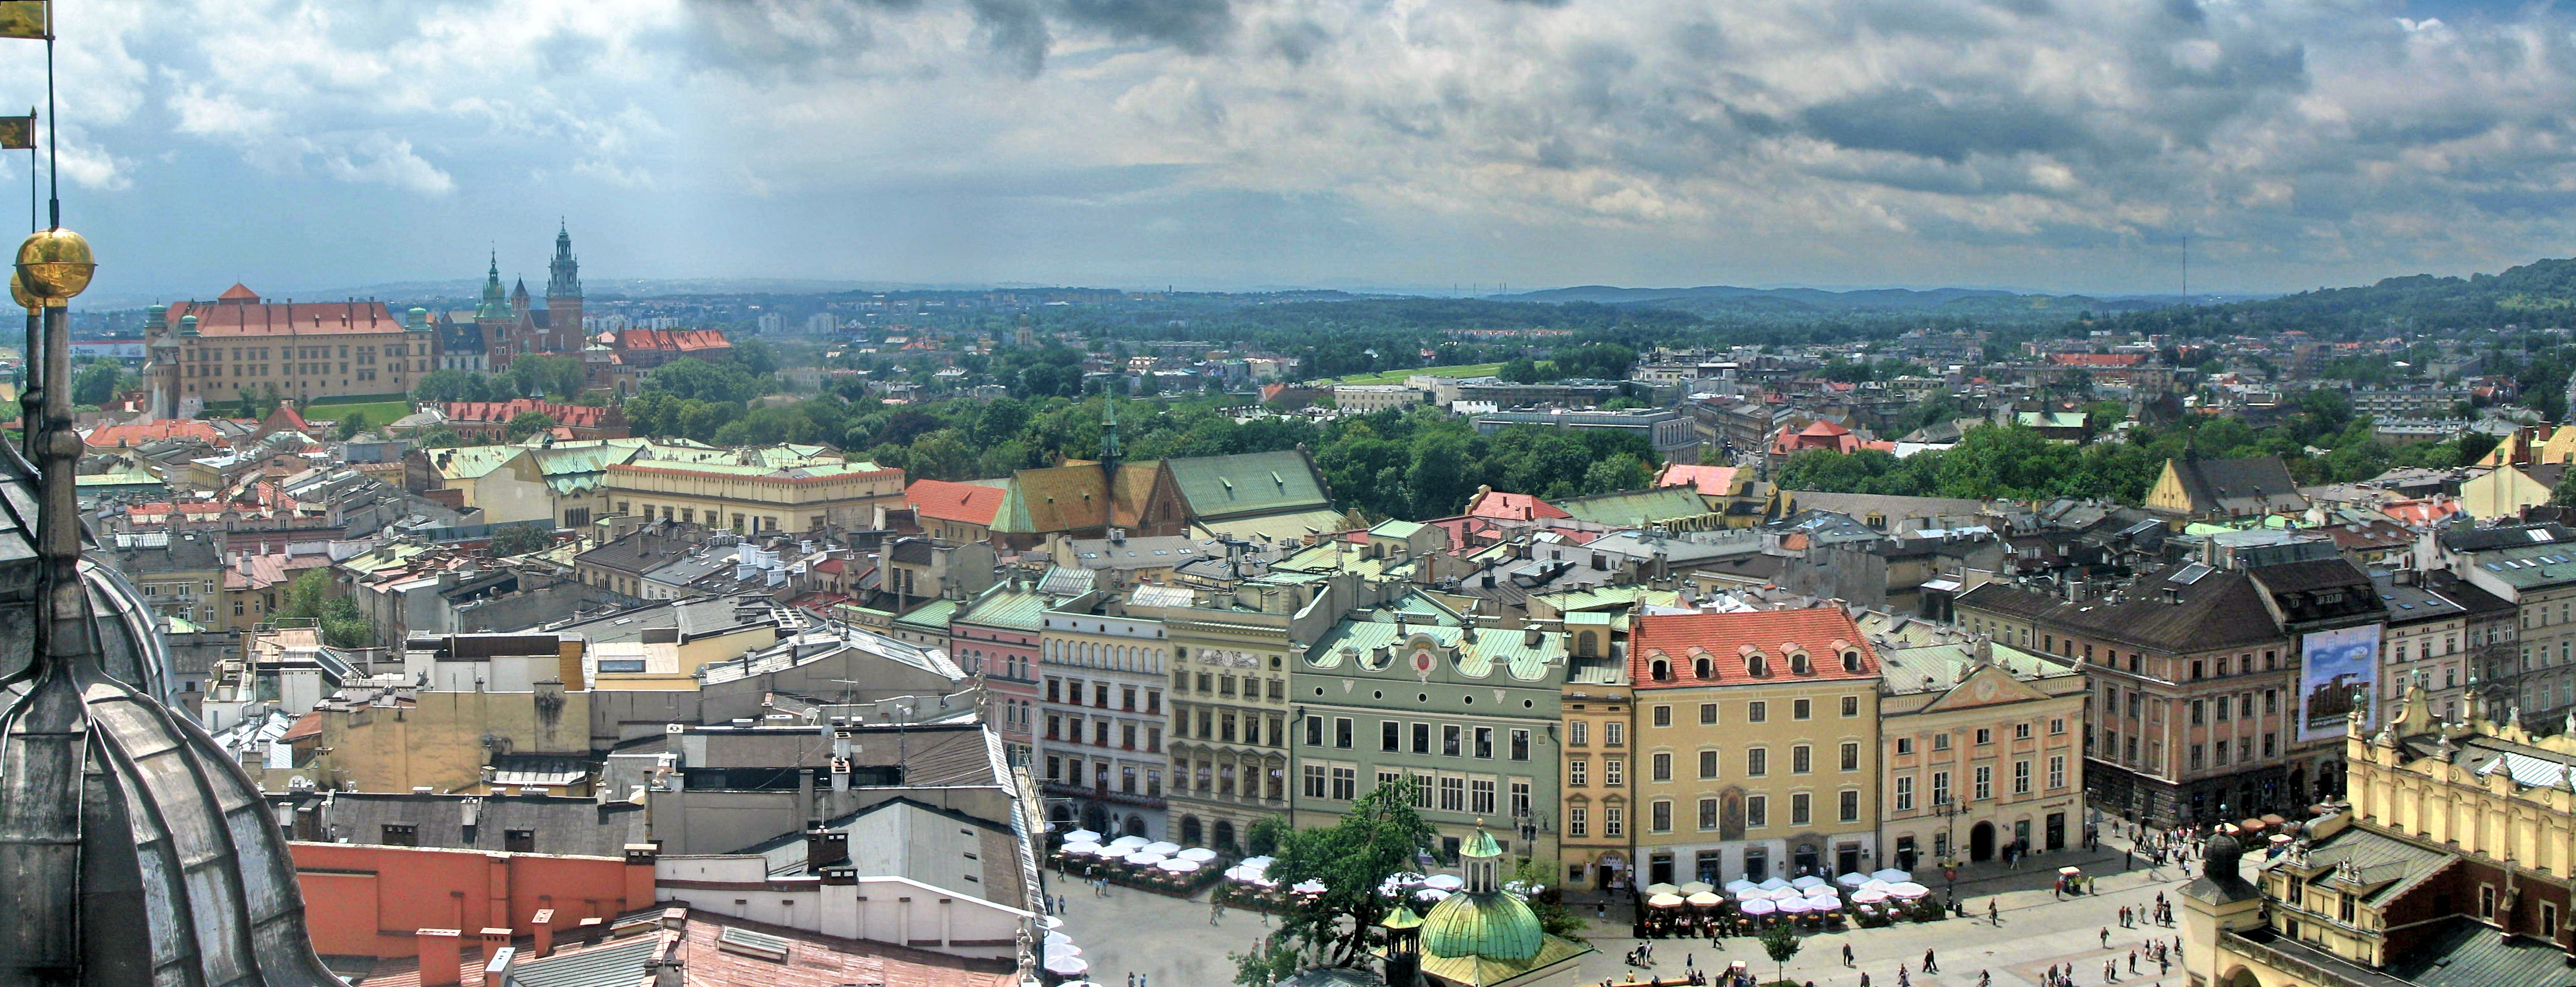

In [50]:
Image(filename=os.path.join(data_dir, 'krakow.jpg'), width=1000)

### Cracow + Van Gogh, Cracow + Kandinsky
Display the pictures after Van Gogh and Kandinsky styles have been applied.

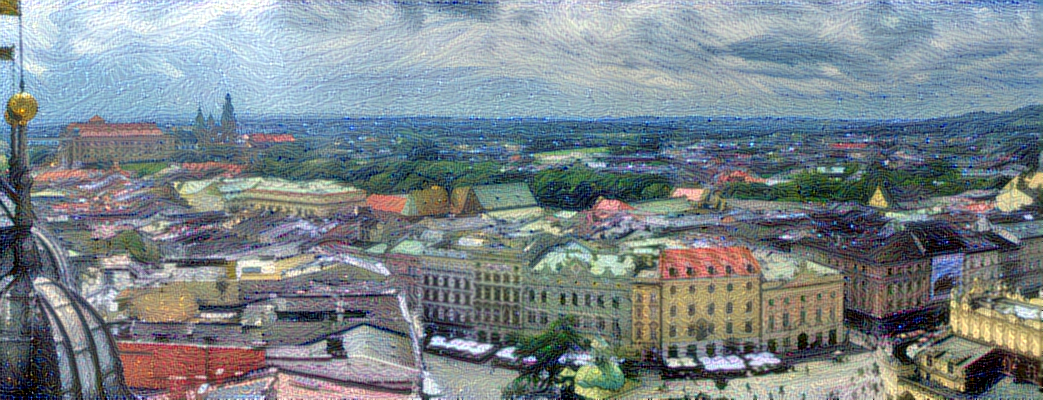

In [51]:
Image(filename=transfered_images[1], width=1000)

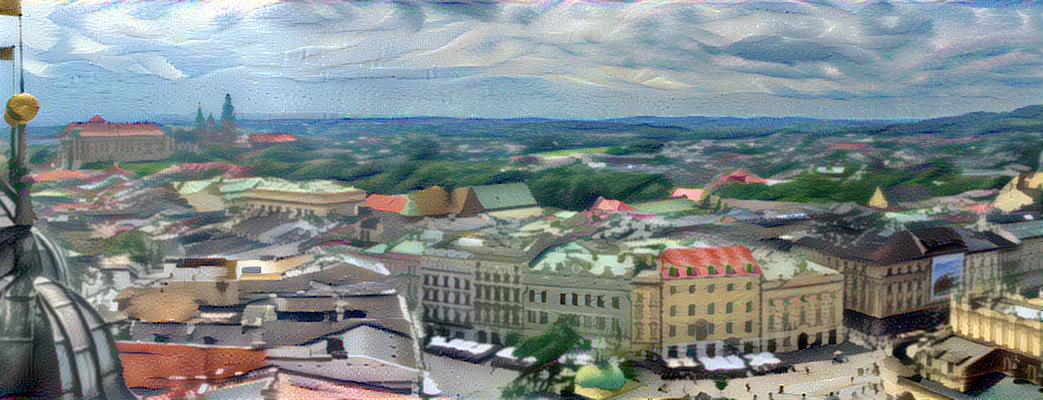

In [52]:
Image(filename=transfered_images[0], width=1000)

<HR>

<a id="summary"></a>
## 6. Summary    

 You successfully completed this notebook! You learned how to use `watson-machine-learning-client` to run experiments. Check out our:
- <a href="https://github.com/pmservice/style-transfer" target="_blank" rel="noopener noreferrer">Sample python web application for style transfer</a> 
- <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener noreferrer">Online Documentation</a> for more samples, tutorials, documentation, how-tos, and blog posts

### Citations

- <a href="https://commons.wikimedia.org/wiki/User:Rj1979">Rj1979</a>, <a href="https://commons.wikimedia.org/wiki/File:Kraków_239a.jpg">Kraków 239a</a>, marked as public domain, more details on <a href="https://commons.wikimedia.org/wiki/Template:PD-self">Wikimedia Commons</a>
- <a href="https://en.wikipedia.org/wiki/en:Vincent_van_Gogh">Vincent van Gogh</a>, <a href="https://commons.wikimedia.org/wiki/File:Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg">Van Gogh - Starry Night - Google Art Project</a>, marked as public domain, more details on <a href="https://commons.wikimedia.org/wiki/Template:PD-1923">Wikimedia Commons</a>
- <a href="https://en.wikipedia.org/wiki/en:Wassily_Kandinsky">Wassily Kandinski</a>, <a href="https://commons.wikimedia.org/wiki/File:Kandinsky,_Lyrisches.jpg">Kandinsky, Lyrisches</a>, marked as public domain, more details on <a href="https://commons.wikimedia.org/wiki/Template:PD-1923">Wikimedia Commons</a>


### Author

**Lukasz Cmielowski**, PhD, is an Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.

<hr>Copyright © 2018-2020 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>